In [1]:
from SupertypeTools import CGCalcMat, heatmap, SSE, hierarchical_cluster
import pandas as pd
import matplotlib.pyplot as plt
# contact = [7,9,24,45,59,62,63,66,67,69,70,73,74,76,77,80,81,84,95,97,99,114,116,118,143,147,150,152,156,158,159,163,167,171] #MHCpan
# contactA = [5,7,9,24,25,34,45,59,63,66,67,70,74,77,80,81,84,97,99,113,114,116,123,133,143,146,147,152,155,156,159,160,163,167,171]
# contactB = [5,7,8,9,24,45,59,62,63,65,66,67,70,73,74,76,77,80,81,84,95,97,99,114,116,123,143,146,147,152,155,156,159,160,163,167,171]

# weight = {3:[7,9,24,45,62,63,66,67,70,74,77,80,81,84,95,97,99,116,118,143,147,159]}

#Hanneke W.M. van Deutekom and Can Kesmir 2015
contact = [7,9,24,45,59,63,66,67,69,70,74,76,77,80,95,97,99,114,116,152,156,158,163,167,171]
weight = {9.9:[63],7.6:[67],5.8:[116],5.4:[9],4.7:[97],4.6:[152],3.8:[167],3.7:[156],3.6:[74],3.2:[70],3:[80],2.9:[171],2.8:[45],2.7:[66],2.7:[77],2.4:[76],2.3:[114],2.1:[99],1.5:[163],1.5:[95],1.4:[59],1.4:[158],1.2:[69],1.2:[24],1:[7]}

## Archive

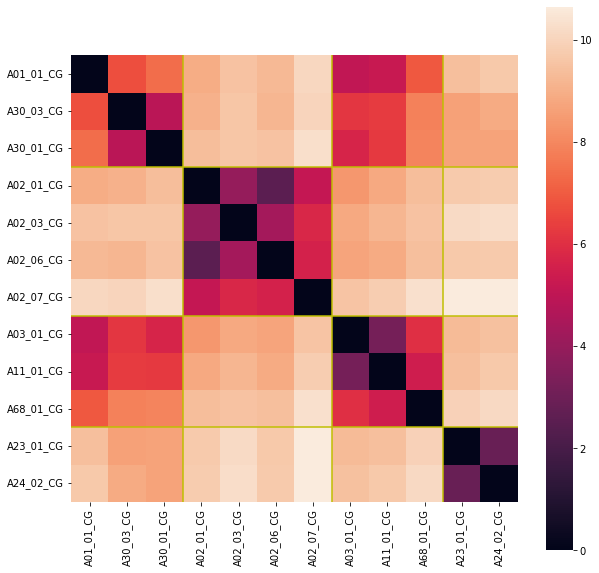

In [2]:
# crystal structure
A_crystal_mean_order = [['A01_01_CG', 'A30_03_CG', 'A30_01_CG'],
    ['A02_01_CG', 'A02_03_CG', 'A02_06_CG', 'A02_07_CG'],
    ['A03_01_CG', 'A11_01_CG', 'A68_01_CG'],
    ['A23_01_CG', 'A24_02_CG']]

Mat = CGCalcMat("../crystal/A_mean/CG_DAT", "../crystal/A_mean/HLA-A_mean_CG.csv", contact=contact, weight=weight)
heatmap(Mat, A_crystal_mean_order)

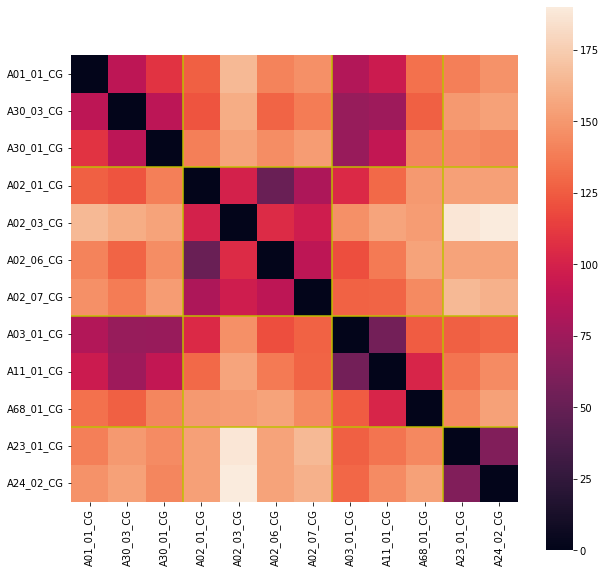

In [9]:
# crystal structure pairwise
A_crystal_mean_order = [['A01_01_CG', 'A30_03_CG', 'A30_01_CG'],
    ['A02_01_CG', 'A02_03_CG', 'A02_06_CG', 'A02_07_CG'],
    ['A03_01_CG', 'A11_01_CG', 'A68_01_CG'],
    ['A23_01_CG', 'A24_02_CG']]

Mat = CGCalcMat("../crystal/A_mean/CG_DAT", "../crystal/A_mean/HLA-A_mean_CG.csv", contact=contact, weight=weight, pairwise=True)
heatmap(Mat, A_crystal_mean_order)

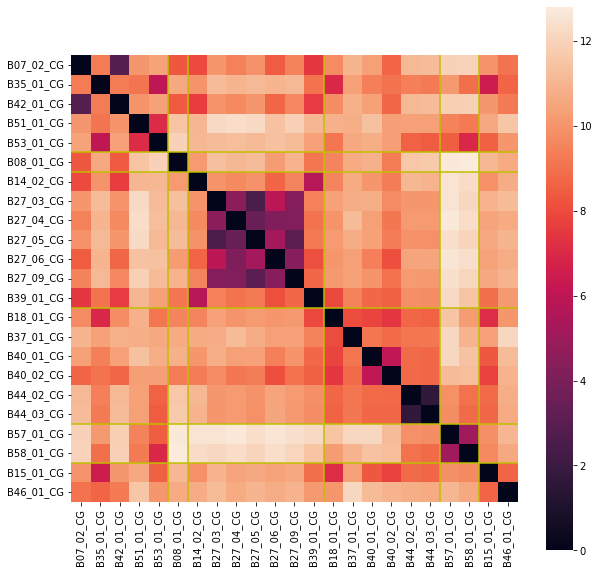

In [7]:
B_crystal_mean_order = [["B07_02_CG","B35_01_CG","B42_01_CG","B51_01_CG","B53_01_CG"],
    ["B08_01_CG"],
    ["B14_02_CG","B27_03_CG","B27_04_CG","B27_05_CG","B27_06_CG","B27_09_CG","B39_01_CG"],
    ["B18_01_CG","B37_01_CG","B40_01_CG","B40_02_CG","B44_02_CG","B44_03_CG"],
    ["B57_01_CG","B58_01_CG"],
    ["B15_01_CG","B46_01_CG"]]

Mat = CGCalcMat("../crystal/B_mean/CG_DAT", "../crystal/A_mean/HLA-B_mean_CG.csv", contact=contact, weight=weight)
heatmap(Mat, B_crystal_mean_order)

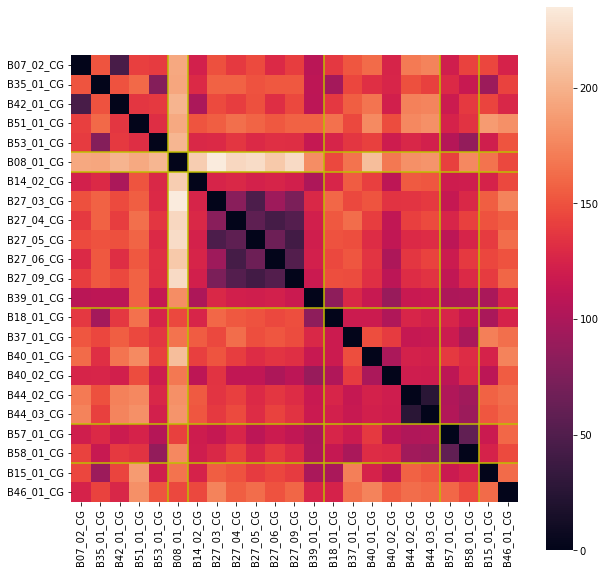

In [10]:
B_crystal_mean_order = [["B07_02_CG","B35_01_CG","B42_01_CG","B51_01_CG","B53_01_CG"],
    ["B08_01_CG"],
    ["B14_02_CG","B27_03_CG","B27_04_CG","B27_05_CG","B27_06_CG","B27_09_CG","B39_01_CG"],
    ["B18_01_CG","B37_01_CG","B40_01_CG","B40_02_CG","B44_02_CG","B44_03_CG"],
    ["B57_01_CG","B58_01_CG"],
    ["B15_01_CG","B46_01_CG"]]

Mat = CGCalcMat("../crystal/B_mean/CG_DAT", "../crystal/A_mean/HLA-B_mean_CG.csv", contact=contact, weight=weight, pairwise=True)
heatmap(Mat, B_crystal_mean_order)

## Tuning number of clusters

In [25]:
def Tuning_N(StructureDistMat, BADistMat, Nmin, Nmax):
    StructSSE = []
    BASSE = []

    # dist_list = []

    for i in range(Nmin, Nmax+1):
        cluster, _ = hierarchical_cluster(StructureDistMat, N=i, L='complete', threshold=None, compute_distances=False)
        #complete average single
        groups = [i[1].index.tolist() for i in cluster.groupby(cluster)]
        # print(groups)
        
        Struct_err = SSE(StructureDistMat, groups)
        StructSSE.append(Struct_err)

        if BADistMat is not None:
            BA_err = SSE(BADistMat, groups)
            BASSE.append(BA_err)

        else:
            BA_err = 'NA'

        print(f"N={i}  SE: {Struct_err} / BE: {BA_err}")

        # dist_list.append(dist)

    return StructSSE, BASSE

def elbow_plot(Struct_Mat, BA_Mat, Additional_Bar_group:list=None, Nmin=1, Nmax=12):
    
    SSE_struct, SSE_BA = Tuning_N(Struct_Mat, BA_Mat, Nmin, Nmax)
    xx = range(Nmin, Nmax+1)

    lines = []
    labels = []

    fig, ax1 = plt.subplots(figsize=(4,6))
    ax2 = ax1.twinx()

    line1, = ax1.plot(xx, SSE_BA, c='b', marker='^', mfc='None', mec='b', ms='8', mew=3, alpha=0.6, label="NetMHCpan SSE")
    line2, = ax2.plot(xx, SSE_struct, c='g', marker='v', mfc='None', mec='g', ms='8', mew=3, alpha=0.6, label="Structure SSE")
    lines.append(line1)
    labels.append("NetMHCpan SSE")
    lines.append(line2)
    labels.append("Structure SSE")

    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Binding peptide SSE', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2.set_ylabel('Structure distance SSE', color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    if Additional_Bar_group:
        for group in Additional_Bar_group:
            lines.append(ax1.bar(group[0], group[1], alpha=0.6, label=group[2], linewidth=2, edgecolor='b'))
            labels.append(f"{group[2]} (n={group[0]})")

    # ax1.legend()
    # ax2.legend()
    ax1.legend(lines, labels)
    ax1.grid(linestyle='--')

    # fig.legend()
    plt.show()

    return

BA_Mat = pd.read_csv("../BA_pred/top10_matrix.csv", index_col=0)

### HLA-A

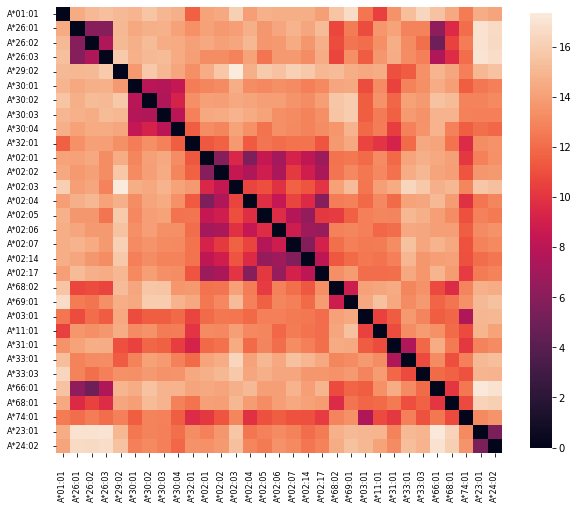

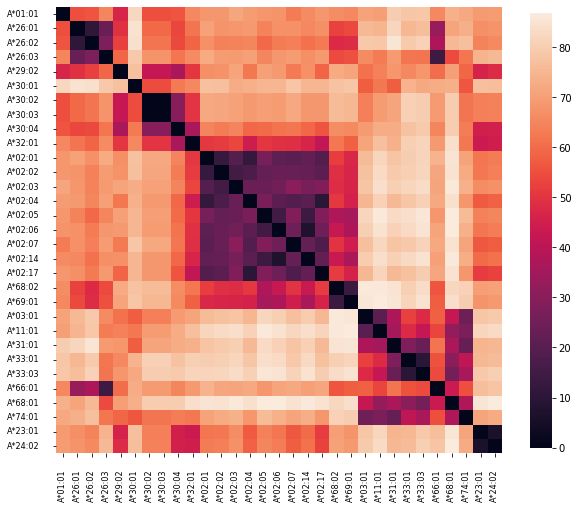

In [9]:
AMat = CGCalcMat("../Figures/Figure3_compare_to_existing_supertype/HLA-A/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-A.list", contact=contact, weight=weight)
A_order = [
    ['A01_01', 'A26_01', 'A26_02', 'A26_03', 'A29_02', 'A30_01', 'A30_02', 'A30_03', 'A30_04', 'A32_01'],
    ['A02_01', 'A02_02', 'A02_03', 'A02_04', 'A02_05', 'A02_06', 'A02_07', 'A02_14', 'A02_17', 'A68_02', 'A69_01'],
    ['A03_01', 'A11_01', 'A31_01', 'A33_01', 'A33_03', 'A66_01', 'A68_01', 'A74_01'],
    ['A23_01', 'A24_02']
    ]
A_label = ['A*01:01', 'A*26:01', 'A*26:02', 'A*26:03', 'A*29:02', 'A*30:01', 'A*30:02', 'A*30:03', 'A*30:04', 'A*32:01', 'A*02:01', 'A*02:02', 'A*02:03', 'A*02:04', 'A*02:05', 'A*02:06', 'A*02:07', 'A*02:14', 'A*02:17', 'A*68:02', 'A*69:01', 'A*03:01', 'A*11:01', 'A*31:01', 'A*33:01', 'A*33:03', 'A*66:01', 'A*68:01', 'A*74:01', 'A*23:01', 'A*24:02']
heatmap(AMat, A_order, label=A_label, line=False, shrink=0.8)
heatmap(BA_Mat, A_order, label=A_label, line=False, shrink=0.8)

N=1  SE: 5983.319966476416 / BE: 28715.49090909091
N=2  SE: 2675.1190385428495 / BE: 12221.654545454545
N=3  SE: 1805.5292354888015 / BE: 8091.236363636364
N=4  SE: 1079.4907778407492 / BE: 4509.654545454546
N=5  SE: 887.2886933761 / BE: 3679.281818181818
N=6  SE: 745.3408190392977 / BE: 2918.9181818181814
N=7  SE: 644.7438526648122 / BE: 2419.590909090909
N=8  SE: 583.4968662049205 / BE: 2120.181818181818
N=9  SE: 536.5766530867836 / BE: 1842.527272727273
N=10  SE: 366.4874887750079 / BE: 1443.2454545454548
N=11  SE: 344.0240771230137 / BE: 1309.8
N=12  SE: 302.40823515184695 / BE: 1128.9818181818184


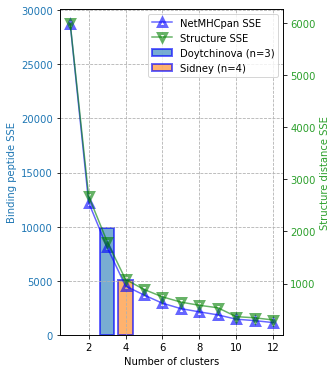

Sidney SSE:5091.036363636364
Doytchinova SSE:9840.300000000003


In [26]:
# Sidney
A_Sidney = [
    ['A01_01', 'A26_01', 'A26_02', 'A26_03', 'A29_02', 'A30_01', 'A30_02', 'A30_03', 'A30_04', 'A32_01'],
    ['A02_01', 'A02_02', 'A02_03', 'A02_04', 'A02_05', 'A02_06', 'A02_07', 'A02_14', 'A02_17', 'A68_02', 'A69_01'],
    ['A03_01', 'A11_01', 'A31_01', 'A33_01', 'A33_03', 'A66_01', 'A68_01', 'A74_01'],
    ['A23_01', 'A24_02']
    ]

# Doytchinova
A_Doytchinova = [
    ['A01_01','A29_02','A30_01','A30_02','A30_03','A30_04','A32_01','A03_01','A11_01','A31_01','A33_01','A33_03','A66_01','A68_01','A74_01'],
    ['A26_01','A26_02','A26_03','A02_01','A02_02','A02_03','A02_04','A02_05','A02_06','A02_07','A02_14','A02_17','A68_02','A69_01'],
    ['A23_01','A24_02']
]
# elbow_plot(Mat, BA_Mat)
ASidney_SSE = SSE(BA_Mat, A_Sidney)
ADoytchinova_SSE = SSE(BA_Mat, A_Doytchinova)

elbow_plot(AMat, BA_Mat, [(len(A_Doytchinova),ADoytchinova_SSE, "Doytchinova"), (len(A_Sidney),ASidney_SSE, "Sidney")])
print(f"Sidney SSE:{ASidney_SSE}\nDoytchinova SSE:{ADoytchinova_SSE}")
# elbow_plot(Mat, BA_Mat)

### HLA-B

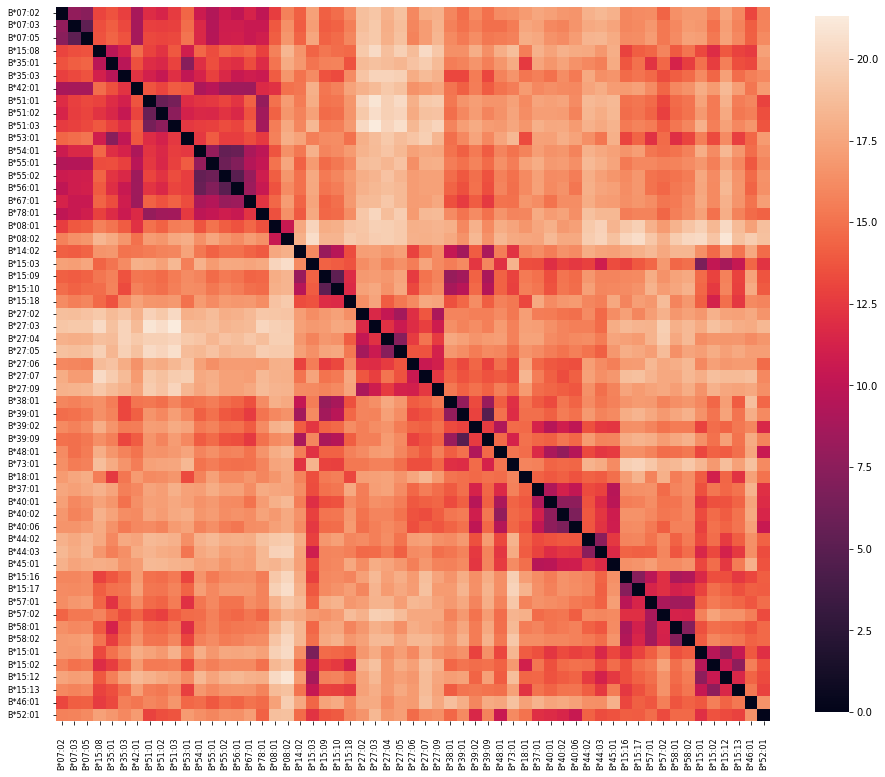

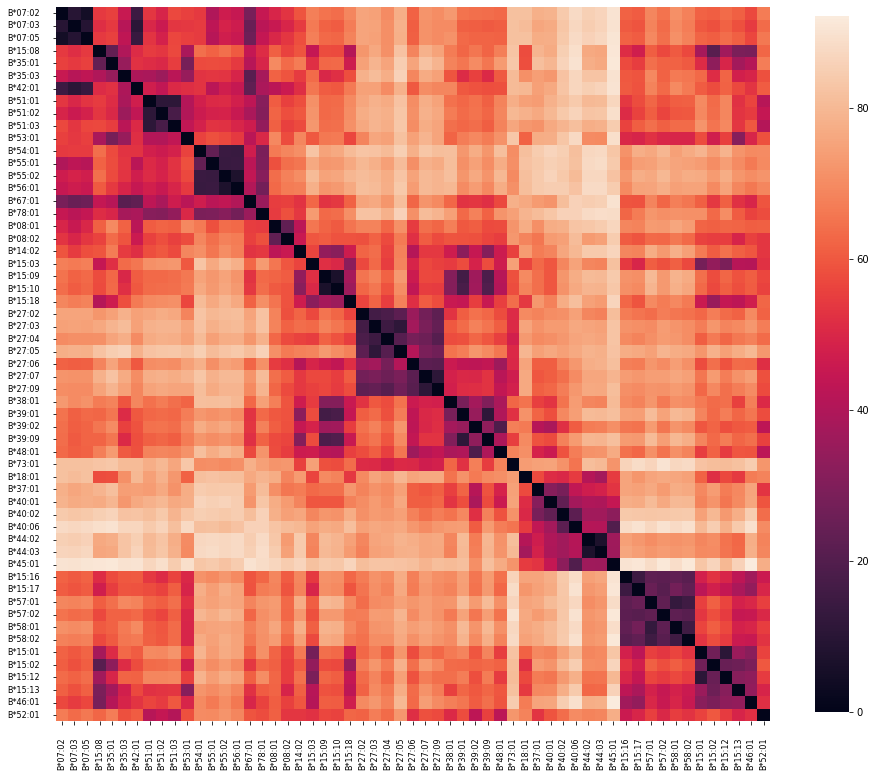

In [13]:
B_order = [
    ['B07_02','B07_03','B07_05','B15_08','B35_01','B35_03','B42_01','B51_01','B51_02','B51_03','B53_01','B54_01','B55_01','B55_02','B56_01','B67_01','B78_01'],
    ['B08_01','B08_02'],
    ['B14_02','B15_03','B15_09','B15_10','B15_18','B27_02','B27_03','B27_04','B27_05','B27_06','B27_07','B27_09','B38_01','B39_01','B39_02','B39_09','B48_01','B73_01'],
    ['B18_01','B37_01','B40_01','B40_02','B40_06','B44_02','B44_03','B45_01'],
    ['B15_16','B15_17','B57_01','B57_02','B58_01','B58_02'],
    ['B15_01','B15_02','B15_12','B15_13','B46_01','B52_01']
    ]
B_label = ['B*07:02','B*07:03','B*07:05','B*15:08','B*35:01','B*35:03','B*42:01','B*51:01','B*51:02','B*51:03','B*53:01','B*54:01','B*55:01','B*55:02','B*56:01','B*67:01','B*78:01','B*08:01','B*08:02','B*14:02','B*15:03','B*15:09','B*15:10','B*15:18','B*27:02','B*27:03','B*27:04','B*27:05','B*27:06','B*27:07','B*27:09','B*38:01','B*39:01','B*39:02','B*39:09','B*48:01','B*73:01','B*18:01','B*37:01','B*40:01','B*40:02','B*40:06','B*44:02','B*44:03','B*45:01','B*15:16','B*15:17','B*57:01','B*57:02','B*58:01','B*58:02','B*15:01','B*15:02','B*15:12','B*15:13','B*46:01','B*52:01']

BMat = CGCalcMat("../Figures/Figure3_compare_to_existing_supertype/HLA-B/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-B.list", contact=contact, weight=weight)
heatmap(BMat, B_order, size=(16,16), label=B_label, line=False, shrink=0.8)
heatmap(BA_Mat, B_order, size=(16,16), label=B_label, line=False, shrink=0.8)

N=1  SE: 24600.799489549834 / BE: 100988.34545454546
N=2  SE: 11049.7384423414 / BE: 44062.88181818182
N=3  SE: 10255.135474818684 / BE: 41154.91818181819
N=4  SE: 6508.9551043182155 / BE: 25537.0
N=5  SE: 5526.055843278852 / BE: 20900.572727272727
N=6  SE: 4764.035699634002 / BE: 18139.18181818182
N=7  SE: 2964.0219710394936 / BE: 10586.445454545454
N=8  SE: 2879.3584299644826 / BE: 10326.272727272728
N=9  SE: 1960.8174438770056 / BE: 6801.518181818182
N=10  SE: 1831.9744302425654 / BE: 6517.7818181818175
N=11  SE: 1700.6431545801406 / BE: 6036.436363636363
N=12  SE: 1408.1356246404505 / BE: 4818.799999999999


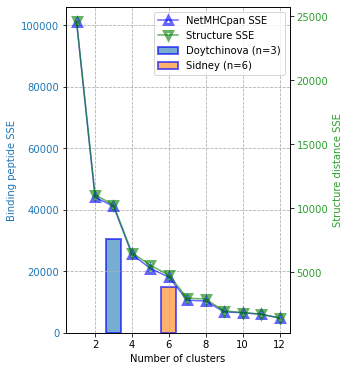

Sidney SSE:14936.072727272725
Doytchinova SSE:30368.809090909093


In [27]:
# Sidney
B_Sidney = [
    ['B07_02','B07_03','B07_05','B15_08','B35_01','B35_03','B42_01','B51_01','B51_02','B51_03','B53_01','B54_01','B55_01','B55_02','B56_01','B67_01','B78_01'],
    ['B08_01','B08_02'],
    ['B14_02','B15_03','B15_09','B15_10','B15_18','B27_02','B27_03','B27_04','B27_05','B27_06','B27_07','B27_09','B38_01','B39_01','B39_02','B39_09','B48_01','B73_01'],
    ['B18_01','B37_01','B40_01','B40_02','B40_06','B44_02','B44_03','B45_01'],
    ['B15_16','B15_17','B57_01','B57_02','B58_01','B58_02'],
    ['B15_01','B15_02','B15_12','B15_13','B46_01','B52_01']
    ]
# Doytchinova
B_Doytchinova = [
    ['B07_02','B07_03','B07_05','B15_08','B35_01','B35_03','B42_01','B54_01','B55_01','B55_02','B56_01','B67_01','B78_01','B08_01','B14_02','B15_09','B15_10','B15_18','B39_01','B39_09','B73_01','B18_01','B15_02'],
    ['B51_01','B51_02','B51_03','B53_01','B08_02','B27_02','B38_01','B44_02','B44_03','B57_01','B57_02','B58_01','B58_02','B52_01'],
    ['B15_03','B27_03','B27_04','B27_05','B27_06','B27_07','B27_09','B39_02','B48_01','B37_01','B40_01','B40_02','B40_06','B45_01','B15_16','B15_17','B15_01','B15_12','B15_13','B46_01']
]

BSidney_SSE = SSE(BA_Mat, B_Sidney)
BDoytchinova_SSE = SSE(BA_Mat, B_Doytchinova)

elbow_plot(BMat, BA_Mat, [(len(B_Doytchinova),BDoytchinova_SSE, "Doytchinova"), (len(B_Sidney),BSidney_SSE, "Sidney")])
print(f"Sidney SSE:{BSidney_SSE}\nDoytchinova SSE:{BDoytchinova_SSE}")

### HLA-C

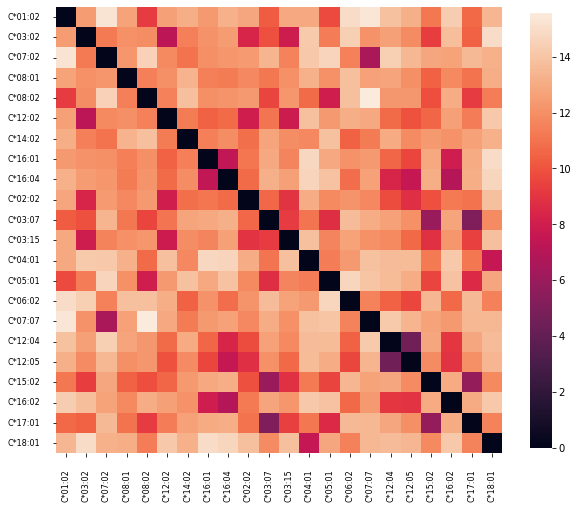

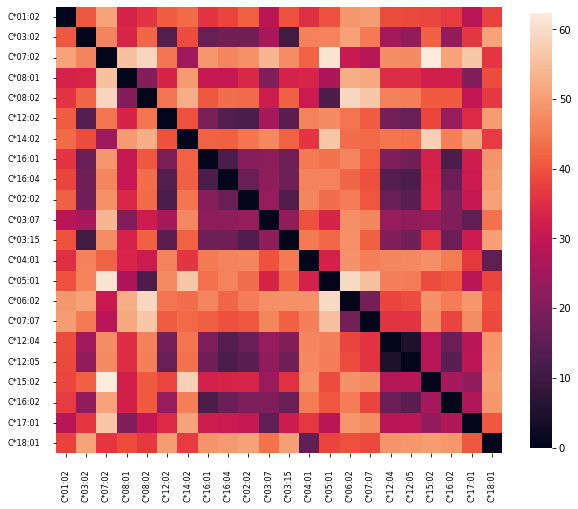

In [15]:
C_order = [
    ['C01_02','C03_02','C07_02','C08_01','C08_02','C12_02','C14_02','C16_01','C16_04'],
    ['C02_02','C03_07','C03_15','C04_01','C05_01','C06_02','C07_07','C12_04','C12_05','C15_02','C16_02','C17_01','C18_01']
]
C_label = ['C*01:02','C*03:02','C*07:02','C*08:01','C*08:02','C*12:02','C*14:02','C*16:01','C*16:04','C*02:02','C*03:07','C*03:15','C*04:01','C*05:01','C*06:02','C*07:07','C*12:04','C*12:05','C*15:02','C*16:02','C*17:01','C*18:01']

CMat = CGCalcMat("../Figures/Figure3_compare_to_existing_supertype/HLA-C/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-C.list", contact=contact, weight=weight)
heatmap(CMat, C_order, label=C_label, line=False, shrink=0.8)

BA_Mat = pd.read_csv("../BA_pred/top10_matrix.csv", index_col=0)
heatmap(BA_Mat, C_order, label=C_label, line=False, shrink=0.8)

N=1  SE: 2730.439507604324 / BE: 8403.51818181818
N=2  SE: 1201.6314072152682 / BE: 3717.545454545455
N=3  SE: 813.1218612554426 / BE: 2413.4818181818187
N=4  SE: 733.530564568082 / BE: 2178.127272727273
N=5  SE: 464.2561529522309 / BE: 1285.3000000000002
N=6  SE: 376.75560309833224 / BE: 1054.6545454545455
N=7  SE: 207.66839366903417 / BE: 542.1090909090908
N=8  SE: 185.40318710305155 / BE: 474.52727272727276
N=9  SE: 152.8566284121544 / BE: 401.20909090909095
N=10  SE: 132.86588836177674 / BE: 324.0363636363637
N=11  SE: 113.89490137604245 / BE: 248.20909090909095
N=12  SE: 88.60091298151015 / BE: 205.0272727272727


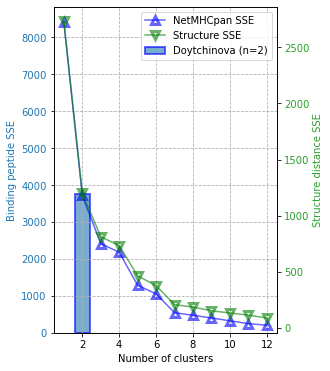

Doytchinova SSE:3752.4181818181814


In [28]:
# Doytchinova
C_Doytchinova = [
    ['C01_02','C03_02','C07_02','C08_01','C12_02','C14_02','C16_01','C16_04'],
    ['C02_02','C03_07','C03_15','C04_01','C05_01','C06_02','C07_07','C12_04','C12_05','C15_02','C16_02','C17_01','C18_01']
]
CDoytchinova_SSE = SSE(BA_Mat, C_Doytchinova)

elbow_plot(CMat, BA_Mat, [(len(C_Doytchinova),CDoytchinova_SSE, "Doytchinova")])
print(f"Doytchinova SSE:{CDoytchinova_SSE}")

### All HLA I alleles

N=3  SE: 544169.6776793506 / BE: NA
N=4  SE: 535131.8439212093 / BE: NA
N=5  SE: 321787.2419064289 / BE: NA
N=6  SE: 267392.96796499105 / BE: NA
N=7  SE: 251478.217917841 / BE: NA
N=8  SE: 230436.62623938522 / BE: NA
N=9  SE: 180887.69666796352 / BE: NA
N=10  SE: 176639.30154302352 / BE: NA
N=11  SE: 156344.20298308393 / BE: NA
N=12  SE: 143838.309985677 / BE: NA
N=13  SE: 129563.1706145866 / BE: NA
N=14  SE: 128752.92032631689 / BE: NA
N=15  SE: 126338.76579689479 / BE: NA
N=16  SE: 106807.67412473589 / BE: NA
N=17  SE: 103456.64915962424 / BE: NA
N=18  SE: 99603.93589667234 / BE: NA
N=19  SE: 89123.61938019443 / BE: NA
N=20  SE: 78287.99560174989 / BE: NA
N=21  SE: 75978.09343092276 / BE: NA
N=22  SE: 75649.34397693847 / BE: NA
N=23  SE: 70275.93951744481 / BE: NA
N=24  SE: 52845.95353240954 / BE: NA
N=25  SE: 51946.23218299241 / BE: NA
N=26  SE: 49923.99090653581 / BE: NA
N=27  SE: 49678.58067890736 / BE: NA
N=28  SE: 49313.70907058659 / BE: NA
N=29  SE: 48996.69364706117 / BE: NA
N

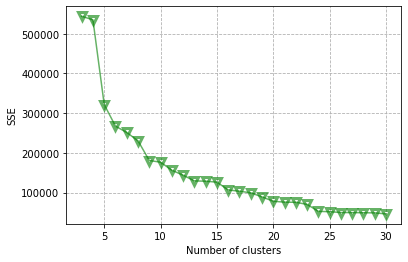

In [29]:
Mat = pd.read_csv("HLA-I_cg_dist.csv", index_col=0)
# elbow_plot(Mat, None, Nmin=3, Nmax=30)
SSE_struct, _ = Tuning_N(Mat, None, 3, 30)
xx = range(3, 31)

plt.figure()
plt.plot(xx, SSE_struct, c='g', marker='v', mfc='None', mec='g', ms='8', mew=3, alpha=0.6, label="SSE")
# plt.legend()
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

plt.grid(linestyle='--')

plt.show()

In [1]:
def test(**kwargs):
    print(kwargs)

test(c_map=5)


{'c_map': 5}
